In [34]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt
import time

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.plot_utils import *

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Building mesh gradient operators
Loading order 0 from file
Loading order 1 from file
Loading order 2 from file


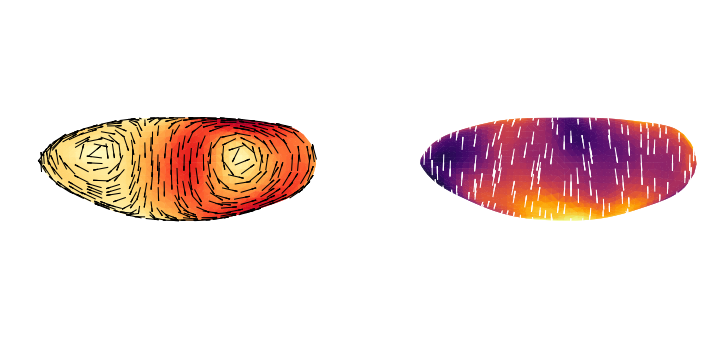

In [155]:
from scipy.io import loadmat
from utils.geometry.plot_utils import *
from utils.geometry.fenics_utils import *
from utils.geometry.transforms import *
from utils.geometry.geometry_utils import *

interp  = MeshInterpolator().fit(None)
tangent = TangentSpaceTransformer().fit(None)
gradient = FenicsGradient_v3(cutoff=0.1).fit(None)

plt.rcParams['figure.dpi'] = 150

info = loadmat('/home/jcolen/fruit_fly/mesh_pinn/FEM_debugging.mat')
V0 = info['u'].transpose(1,0)
M0 = info['myo'].transpose(1, 2, 0)
V0 = LeftRightSymmetrize().fit_transform(V0)
M0 = LeftRightSymmetrize().fit_transform(M0)

fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection='3d'))
plot_vector3D(ax[0], V0)
color_3D(ax[0], np.linalg.norm(V0, axis=0), cmap='YlOrRd')
plot_tensor3D(ax[1], M0)

#Push to tangent space
V0 = tangent.inverse_transform(V0)
M0 = tangent.inverse_transform(M0)

## Build an incompressible Stokes in 2D

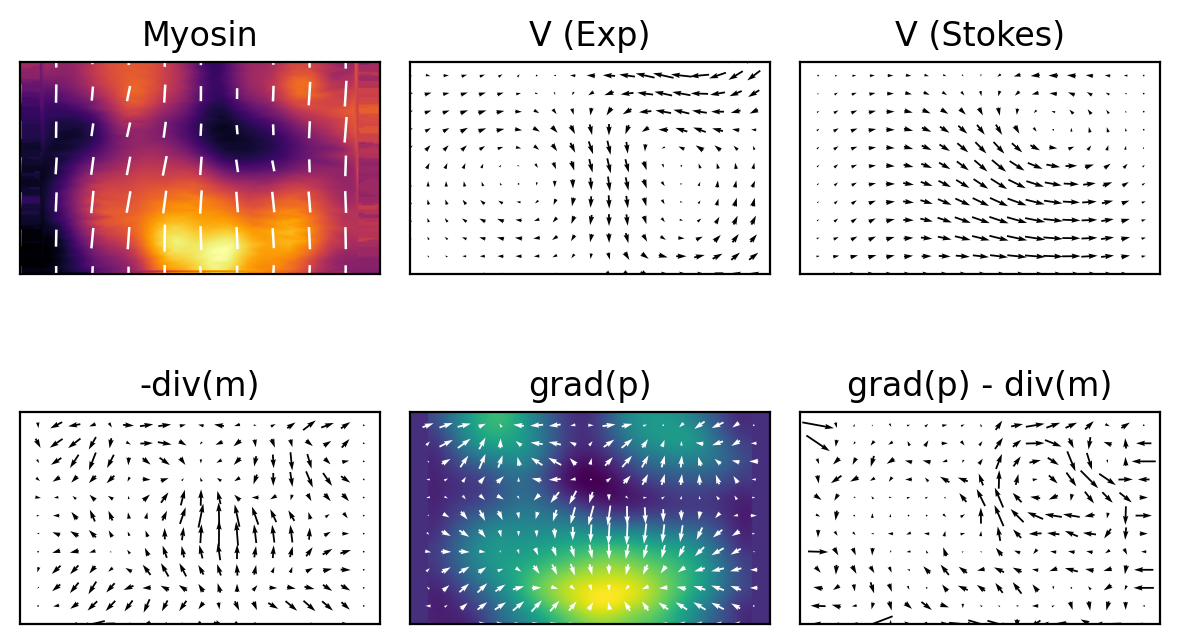

In [156]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from utils.decomposition.decomposition_model import LeftRightSymmetrize
from utils.geometry.geometry_utils import *
from utils.forecasting.transforms import *
from utils.plot_utils import *

from skimage.transform import downscale_local_mean
from scipy import sparse

class FlowSolver(object):
    def __init__(self, nDV=236, nAP=200, sigma=3, mu=1):
        super(FlowSolver, self).__init__()        
        
        self.nDV = nDV
        self.nAP = nAP
        self.sigma = sigma
        self.mu = mu
        
        self.dAP = (ap_max - ap_min) / (nAP -1)
        self.dDV = (dv_max - dv_min) / (nDV -1)
        self.sigma = sigma
        
        self.Gijk = np.load('Public/christoffel_symbols.npy', mmap_mode='r')
        
        #Build poisson matrix
        I_x = sparse.eye(self.nAP)
        I_y = sparse.eye(self.nDV)
        
        D2_x = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(self.nAP, self.nAP))
        D2_y = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(self.nDV, self.nDV))
        
        #Dirichlet BCs in AP direction
        D2_x = sparse.lil_matrix(D2_x)
        D2_x[0, [0, 1]] = [1, 0]
        D2_x[-1, [-2, -1]] = [0, 1]
        D2_x = sparse.csr_matrix(D2_x)
        
        #periodic BCs in DV direction
        D2_y = sparse.lil_matrix(D2_y)
        D2_y[0, [-1, 0, 1]] = [1, -2, 1]
        D2_y[-1, [-2, -1, 0]] = [1, -2, 1]
        D2_y = sparse.csr_matrix(D2_y)
        
        D2_x = sparse.kron(I_y, D2_x) / self.dAP**2
        D2_y = sparse.kron(D2_y, I_x) / self.dDV**2
        
        self.A = D2_x + D2_y
        self.mu = mu
        
        self.gradient = EmbryoGradient(sigma=self.sigma)
                
    def boundary_AP(self, f, ap=10):
        f[..., :ap] = 0
        f[..., -ap:] = 0
        return f
        
    def get_velocity(self, t, y):
        #Fit the gradient operator
        self.gradient.fit(y)
        
        #Get myosin and source
        m = y.reshape([2, 2, self.nDV, self.nAP])

        #Gradients
        div_m = np.einsum('ijyxj->iyx',self.gradient(m))
        d2_m = np.einsum('iyxi->yx', self.gradient(div_m))
        
        # Mask poles
        #d2_m = self.boundary_AP(d2_m)
                
        p = sparse.linalg.spsolve(self.A, d2_m.flatten())
        
        p = p.reshape([self.nDV, self.nAP])
        d1_p = self.gradient(p).transpose(2, 0, 1)
        
        p = self.boundary_AP(p)
        div_m = self.boundary_AP(div_m)
        
        rhs = -div_m + d1_p
        rhs = self.boundary_AP(rhs) / self.mu
        
        v_y = sparse.linalg.spsolve(self.A, rhs[0].flatten())
        v_x = sparse.linalg.spsolve(self.A, rhs[1].flatten())
        
        v = np.stack([v_y, v_x]).reshape([2, self.nDV, self.nAP])
                        
        return v, p, div_m

from scipy.io import loadmat
info = loadmat('/home/jcolen/fruit_fly/mesh_pinn/FEM_debugging.mat')
v0 = info['u'].transpose(1,0)
m0 = info['myo'].transpose(1, 2, 0)

interp  = MeshInterpolator().fit(None)
tangent = TangentSpaceTransformer().fit(None)

m0 = interp.inverse_transform(tangent.inverse_transform(m0))
v0 = interp.inverse_transform(tangent.inverse_transform(v0))

m0 = LeftRightSymmetrize().fit_transform(m0.reshape([1, 4, 236, 200]))

model = FlowSolver(mu=1)
v, p, div_m = model.get_velocity(0, m0)

fig, ax = plt.subplots(2, 3, dpi=200)
plot_tensor2D(ax[0, 0], m0)
plot_vector2D(ax[0, 1], v0)
plot_vector2D(ax[1, 0], -div_m)
color_2D(ax[1, 1], p)
plot_vector2D(ax[0, 2], v)
plot_vector2D(ax[1, 1], model.gradient(p).transpose([2, 0, 1]), color='white')
plot_vector2D(ax[1, 2], model.gradient(p).transpose([2, 0, 1]) - div_m)

ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('V (Exp)')
ax[0, 2].set_title('V (Stokes)')

ax[1, 0].set_title('-div(m)')
ax[1, 1].set_title('grad(p)')
ax[1, 2].set_title('grad(p) - div(m)')

plt.tight_layout()

### Finite element method

In [157]:
from fenics import RectangleMesh, Point, SubDomain, DOLFIN_EPS

mesh = RectangleMesh(Point(0., 0.), Point(1., 1.2), 48, 54)

class DirichletBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return bool((x[0] < (DOLFIN_EPS) or \
                     x[0] > (1. - DOLFIN_EPS)) and \
                    on_boundary)
    
    # Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):
    # Bottom boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[1] < (0 + DOLFIN_EPS) and \
                    x[1] > (0 - DOLFIN_EPS) and \
                    on_boundary)
    # Map top boundary (H) to bottom boundary (G)
    def map(self, x, y):
        y[0] = x[0]
        y[1] = x[1] - 1.2

LU Solver: 0.0526 s (7938,)
Krylov Solver: 4.78 s (7938,)
scipy.sparse.spsolve : 0.145 s (7938,)


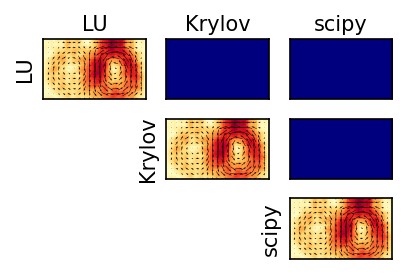

In [158]:
from fenics import VectorElement, FiniteElement, FunctionSpace
v = VectorElement('Lagrange', mesh.ufl_cell(), 1)
vv = VectorElement('Lagrange', mesh.ufl_cell(), 2)
s = FiniteElement('Lagrange', mesh.ufl_cell(), 1)
th = v * s

V = FunctionSpace(mesh, v)
W = FunctionSpace(mesh, th, constrained_domain=PeriodicBoundary())
bc = DirichletBC(W.sub(0), Constant((0., 0.)), DirichletBoundary())

from fenics import dof_to_vertex_map, Function, project
from scipy.interpolate import RectBivariateSpline, griddata
verts = mesh.coordinates()
dm_vs = np.zeros_like(verts)

div_m = np.einsum('ijvj->iv', gradient.transform(M0))
div_m = interp.inverse_transform(div_m)
dm_vs[:, 1] = RectBivariateSpline(
    np.linspace(0, 1.2, 236),
    np.linspace(0, 1, 200),
    div_m[0])(verts[:, 1], verts[:, 0], grid=False)
dm_vs[:, 0] = RectBivariateSpline(
    np.linspace(0, 1.2, 236),
    np.linspace(0, 1, 200),
    div_m[1])(verts[:, 1], verts[:, 0], grid=False)

d2v = dof_to_vertex_map(V)
f = Function(V)
f.vector().set_local(dm_vs.flatten()[d2v])
f = project(f, FunctionSpace(mesh, v, constrained_domain=PeriodicBoundary()))

from fenics import TrialFunctions, TestFunctions, CellDiameter
u, p = TrialFunctions(W)
v, q = TestFunctions(W)

#Stabilized formulation for first-order elements
beta = 0.2
h = CellDiameter(mesh)
delta = beta * h * h

from fenics import inner, grad, div, dx
a = inner(grad(u), grad(v)) * dx + div(v) * p * dx + q * div(u) * dx + delta * inner(grad(p), grad(q)) * dx
L = -inner(-f, v) * dx + delta * inner(-f, grad(q)) * dx

from fenics import assemble_system, KrylovSolver, LUSolver

#Direct solution using LU solver
A, bb = assemble_system(a, L, [bc])
U = Function(W)

solver = LUSolver()
solver.set_operator(A)

t = time.time()

solver.solve(U.vector(), bb)
v1 = U.vector().get_local()

print(f'LU Solver: {time.time() - t:.3g} s',  v1.shape, flush=True)

#Using Krylov subspace method and preconditioner
b = inner(grad(u), grad(v)) * dx + p * q * dx
P, _  = assemble_system(b, L, [bc])

solver = KrylovSolver('minres', 'amg')
solver.set_operators(A, P)

t = time.time()

solver.solve(U.vector(), bb)
v2 = U.vector().get_local()

print(f'Krylov Solver: {time.time() - t:.3g} s',  v2.shape)

#Assemble and solve directly without Krylov iterative solver
A = sparse.csr_matrix(np.asarray(A.array()))
L = sparse.csr_matrix(np.asarray(bb)).T

t = time.time()
v3 = sparse.linalg.spsolve(A, L)

print(f'scipy.sparse.spsolve : {time.time() - t:.3g} s',  v3.shape)

from scipy.interpolate import griddata
def interpolate(v):
    v2d = vertex_to_dof_map(W)
    vi = v[v2d].reshape([mesh.num_vertices(), -1])[:, :-1].T
    verts = mesh.coordinates()
    
    zmin, zmax = verts[:, 0].min(), verts[:, 0].max()
    pmin, pmax = verts[:, 1].min(), verts[:, 1].max()
    z = np.linspace(zmin, zmax, 200)[None, :]
    p = np.linspace(pmin, pmax, 236)[:, None]
    
    vx = griddata(verts, vi[0], (z, p), method='nearest')
    vy = griddata(verts, vi[1], (z, p), method='nearest')
        
    return np.stack([vy, vx])

fig, ax = plt.subplots(3, 3, figsize=(3, 2))
titles = ['LU', 'Krylov', 'scipy']
for i, v in enumerate([v1, v2, v3]):
    ax[i, i].set_ylabel(titles[i])
    ax[0, i].set_xlabel(titles[i])
    ax[0, i].xaxis.set_label_position('top')
    vi = interpolate(v)
    color_2D(ax[i, i], np.linalg.norm(vi, axis=0), cmap='YlOrRd')
    plot_vector2D(ax[i, i], vi, scale=5e-4)
    for j, vv in enumerate([v1, v2, v3]):
        if i > j: 
            ax[i,j].axis('off')
        if i >= j:
            continue
        vj = interpolate(vv)
        color_2D(ax[i, j], residual(vi, vj), cmap='jet', vmin=0, vmax=.1)